# **Lab4 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [160]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure


import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Load Image

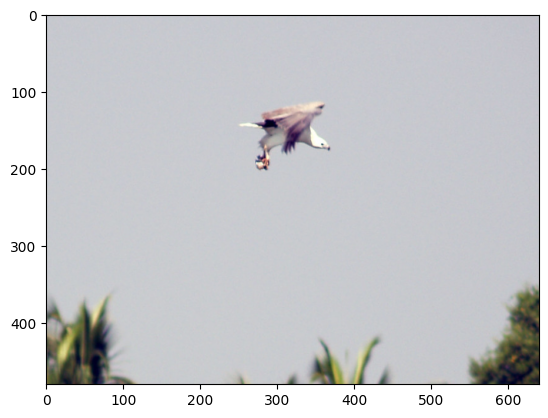

In [161]:
### START CODE HERE ###
image = plt.imread('../images/bird3.jpg')
image = cv2.resize(image, (640, 480))
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/1.png?raw=true)
</details>

(2700378,)


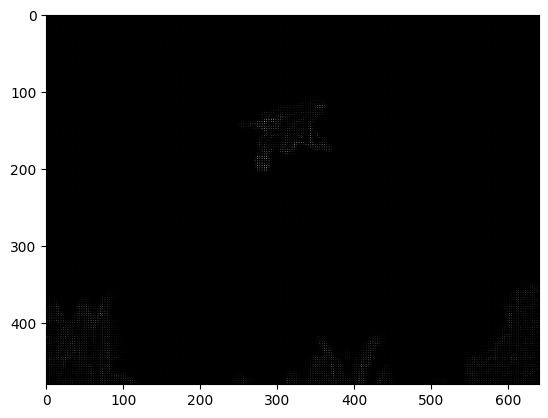

In [162]:
### START CODE HERE ###
blurry_image = cv2.GaussianBlur(image, (5, 5), 0)
fd, hog_image = hog(blurry_image, pixels_per_cell=(3, 3), channel_axis=2, visualize=True)

print(fd.shape)
plt.imshow(hog_image, cmap='gray')

### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [163]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.h, self.w, _ = image.shape
        self.hGrid = [i for i in range(0, self.h - tile_size[0] + 1, stride)]
        self.wGrid = [i for i in range(0, self.w - tile_size[1] + 1, stride)]
        self.hog_features = []
        self.hog_images = []
        self.extract_hog_features()

    def extract_hog_features(self):
        # print(self.tile_size[0]//self.stride)
        self.hog_features, self.hog_images = hog(image, pixels_per_cell=(self.stride, self.stride), cells_per_block=(self.tile_size[0]//self.stride, self.tile_size[1]//self.stride), channel_axis=2, visualize=True)
        # print(self.hog_images.shape, self.hog_features.shape)
        # for y in range(0, self.h - self.tile_size[1] + 1, self.stride):
        #     for x in range(0, self.w - self.tile_size[0] + 1, self.stride):
        #         patch = image[y:y + self.tile_size[1], x:x + self.tile_size[0]]
        #         hog_feature, hog_image = hog(patch, visualize=True)
        #         self.hog_images.append(hog_image)
        #         self.hog_features.append(hog_feature)
                
    def plot_hog_images(self):
        plt.imshow(self.hog_images, cmap='gray')
        # fig, ax = plt.subplots(len(self.hGrid), len(self.wGrid), figsize=(50,50))
        # for i in range(len(self.hGrid)):
        #     for j in range(len(self.wGrid)):
        #         ax[i, j].imshow(self.hog_images[i*len(self.wGrid)+j], cmap="gray")
        #         ax[i, j].set_axis_off()
        # plt.tight_layout()

    def get_num_grid(self):
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###

Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

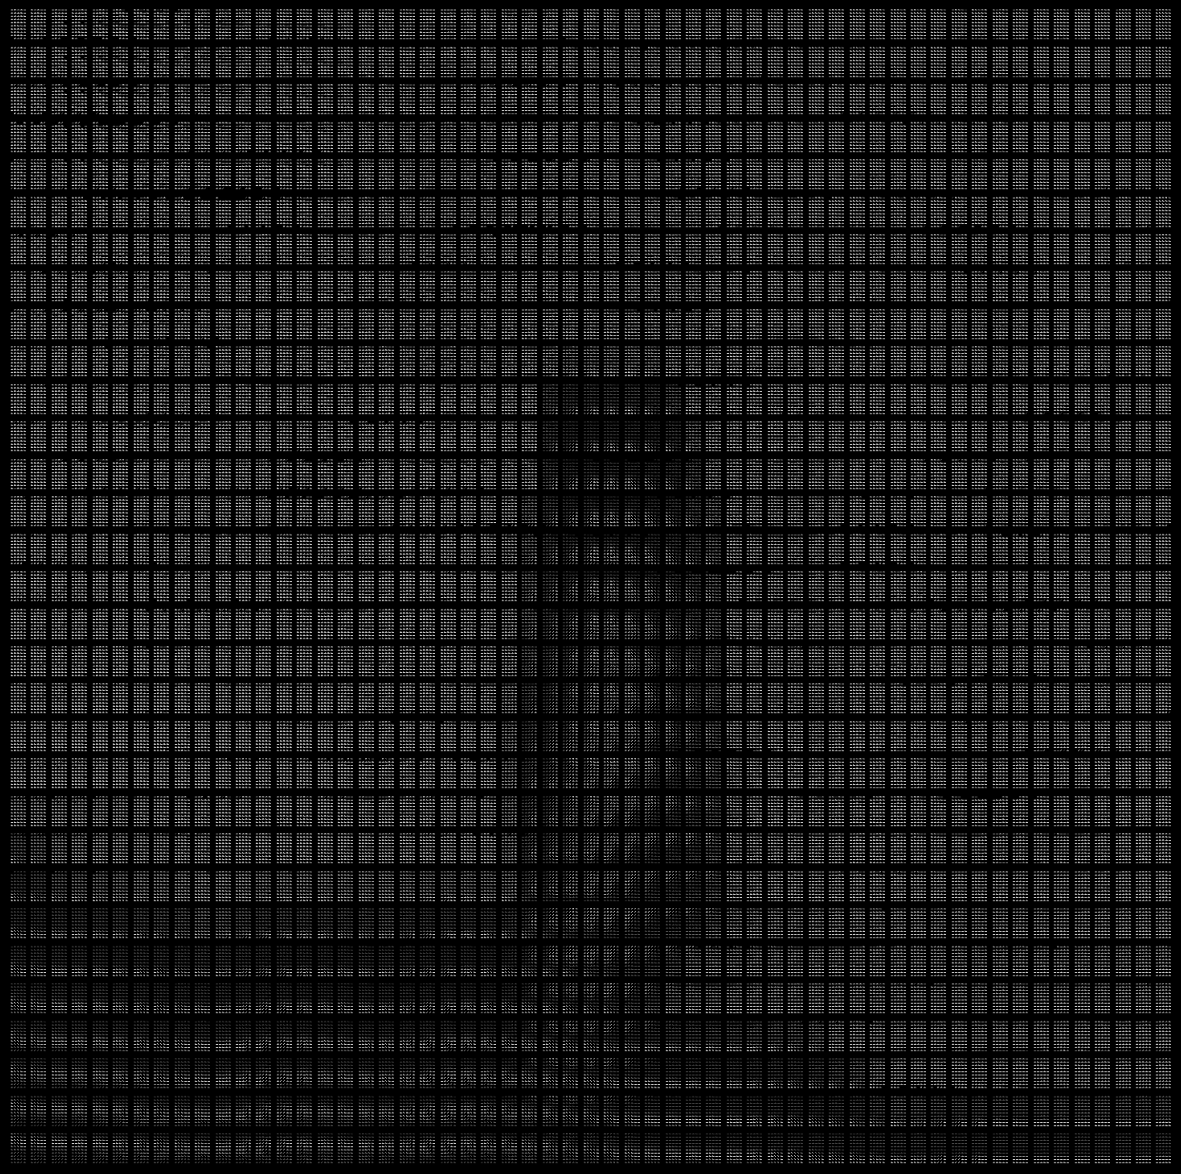
</details>

(1755432,)
(480, 640, 3)
Number of grids: (63, 86)


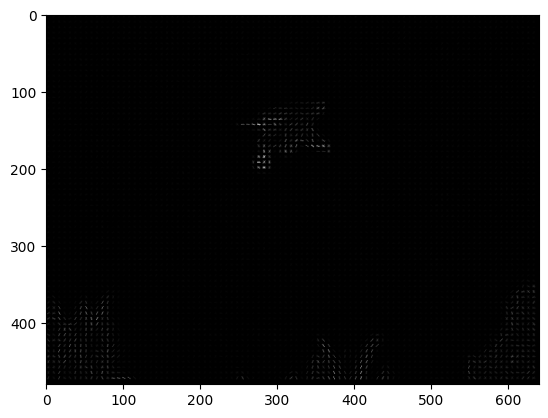

In [164]:
### START CODE HERE ###
tile_size = (42, 42)
stride = 7
hog_extractor = HOGSubimageExtractor(blurry_image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(hog_extractor.hog_features.shape)
print(image.shape)
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###


## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [165]:
### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        h, w = self.hog_extractor.get_num_grid()
        # print(h*w, self.hog_extractor.hog_features.shape)
        # th, tw = self.hog_extractor.tile_size
        # stride = self.hog_extractor.stride
        # features_2d = self.hog_extractor.hog_features.reshape((-1, 9*th*tw//stride//stride))
        features_2d = self.hog_extractor.hog_features.reshape((h*w, -1))
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state).fit(features_2d)
        # print(np.unique(kmeans.fit(features_2d).labels_))
        # print(np.array(self.hog_extractor.hog_features).shape)
        # print(features_2d.shape)
        self.cluster_array = kmeans.predict(features_2d)
        self.cluster_array = self.cluster_array.reshape(h, w)
        # print('**', np.unique(self.cluster_array))
        # print('****', self.cluster_array.shape)
        self.all_labels = measure.label(self.cluster_array)
        # print(self.all_labels)
        # print(self.all_labels.max())
        # print(h, w)
        # self.all_labels = self.all_labels.reshape(h, w)
        # print('***', self.all_labels.max())

    def plot_cluster_and_labels(self):
        # clustered_image = np.zeros(image.shape[:2])
        # labeled_image = np.zeros(image.shape[:2])
        # h, w = self.hog_extractor.get_num_grid()
        # cluster_array_2d = self.cluster_array.reshape(h, w)
        # all_labels_2d = self.all_labels.reshape(h, w)

        # tile_size = self.hog_extractor.tile_size
        # for ni, i in enumerate(hog_extractor.hGrid):
        #     for nj, j in enumerate(hog_extractor.wGrid):
        #         clustered_image[i:i + tile_size[0], j:j + tile_size[1]] = cluster_array_2d[ni, nj]
        #         labeled_image[i:i + tile_size[0], j:j + tile_size[1]] = all_labels_2d[ni, nj]

        # clustered_image = clustered_image / clustered_image.max() * 255
        # labeled_image = labeled_image / labeled_image.max() * 255
                
        # fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
        # ax[0].imshow(clustered_image.astype(np.uint8))
        # ax[0].set_title('Cluster')
        # ax[1].imshow(labeled_image.astype(np.uint8))
        # ax[1].set_title('Labels')
        
        fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
        ax[0].imshow(self.cluster_array.astype(np.uint8))
        ax[0].set_title('Cluster')
        ax[1].imshow(self.all_labels.astype(np.uint8))
        ax[1].set_title('Labels')
        

    def get_bounding_boxes(self):
        # self.all_labels += 1
        # image_label = np.zeros(image.shape[:2])
        # tile_size = self.hog_extractor.tile_size
        # for ni, i in enumerate(hog_extractor.hGrid):
        #     for nj, j in enumerate(hog_extractor.wGrid):
        #         image_label[i:i + tile_size[0], j:j + tile_size[1]] = self.all_labels[ni, nj]
        

        image_label = np.repeat(self.all_labels, stride+1, axis=1)
        image_label = np.repeat(image_label, stride+1, axis=0)
        # print(image_label.shape)

        labels = np.unique(image_label)
        if 0 in labels:
            labels = labels[labels != 0]
        
        bounding_boxes = []
        for label in labels:
            rows, cols = np.where(image_label == label)
            
            min_row, max_row = rows.min(), rows.max()
            min_col, max_col = cols.min(), cols.max()
            
            bounding_boxes.append((min_row, min_col, max_row, max_col))
        
        return bounding_boxes
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [166]:
### START CODE HERE ###
def draw_bbox(image, bboxes):
    img = image.copy()
    for box in bboxes:
        cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (255, 0, 0), 2)
    return img
### END CODE HERE ###


Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/4.png?raw=true)
</details>

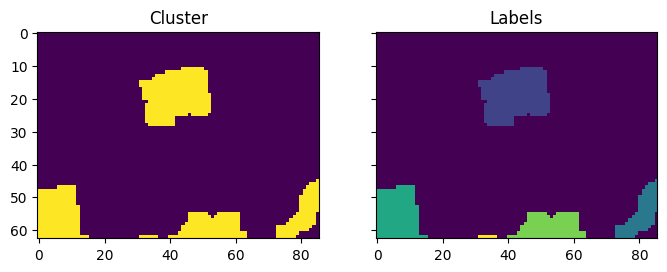

In [167]:
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=0)
kmeans_cluster.plot_cluster_and_labels()
# image_bbox = draw_bbox(image, bboxes)
# plt.imshow(image_bbox)

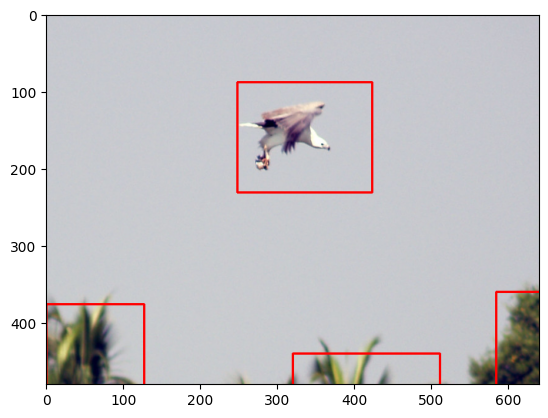

In [168]:
bboxes = kmeans_cluster.get_bounding_boxes()
# image = image.astype(np.uint8)
image_bbox = draw_bbox(image, bboxes)

plt.imshow(image_bbox)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

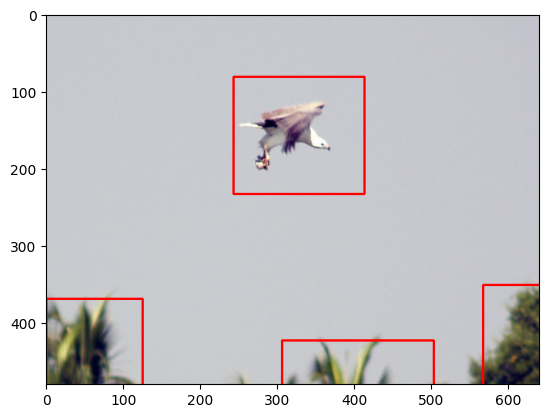

In [169]:
### START CODE HERE ###

tile_size = (48, 48)
stride = 8
n_clusters=2

hog_extractor1 = HOGSubimageExtractor(blurry_image, tile_size, stride)
kmeans_cluster1 = KMeansCluster(hog_extractor1, n_clusters=n_clusters, random_state=0)
bboxes1 = kmeans_cluster1.get_bounding_boxes()
image_bbox1 = draw_bbox(image, bboxes1)

plt.imshow(image_bbox1)


### END CODE HERE ###

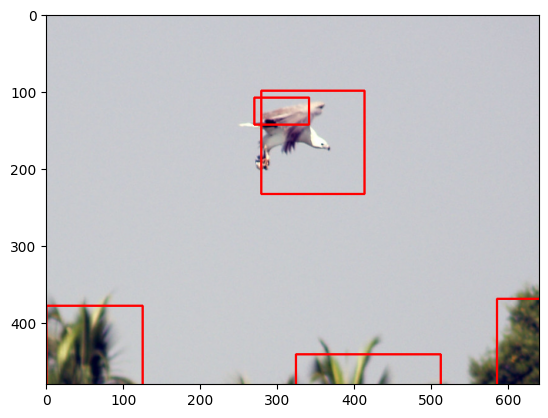

In [170]:
### START CODE HERE ###

tile_size = (32, 32)
stride = 8
n_clusters=2

hog_extractor2 = HOGSubimageExtractor(blurry_image, tile_size, stride)
kmeans_cluster2 = KMeansCluster(hog_extractor2, n_clusters=n_clusters, random_state=0)
bboxes2 = kmeans_cluster2.get_bounding_boxes()
image_bbox2 = draw_bbox(image, bboxes2)

plt.imshow(image_bbox2)


### END CODE HERE ###

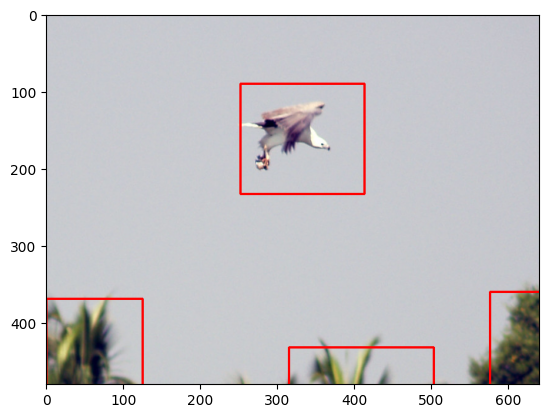

In [171]:
### START CODE HERE ###

tile_size = (40, 40)
stride = 8
n_clusters=2

hog_extractor3 = HOGSubimageExtractor(blurry_image, tile_size, stride)
kmeans_cluster3 = KMeansCluster(hog_extractor3, n_clusters=n_clusters, random_state=0)
bboxes3 = kmeans_cluster3.get_bounding_boxes()
image_bbox3 = draw_bbox(image, bboxes3)

plt.imshow(image_bbox3)


### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?
<br>= kernel size ถ้ามีค่ามากจะทำให้ภาพเบลอมาก แต่ก็อาจทำให้รูปสูญเสียข้อมูลเล็ก ๆ ที่ไม่สำคัญได้ ในทางกลับกัน ถ้า kernel size มีค่าน้อย ก็จะทำให้รูปมีข้อมูลที่ครบถ้วน<br>
  S.D. คือน้ำหนักที่กำหนดให้ pixel รอบ ๆ ถ้า S.D. มีค่ามาก ก็จะทำให้แยกกลุ่มออกมาได้น้อย ส่วน S.D. ที่มีค่าน้อยก็จะทำให้คงรายละเอียดที่มากขึ้น
2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?
<br>= pixels per cell ถ้ามีค่ามาก ก็จะทำให้ละทิ้งรายละเอียดเล็ก ๆ ที่ไม่สำคัญหรือพวก noise ได้ แต่ถ้ามีค่าน้อยก็จะสามารถเก็บรายละเอียดได้มากขึ้น
<br>  cells per block เหมือนกับ pixels per cell
3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?
<br>= รูปเล็กจะจับรายละเอียดเล็ก ๆ ได้ดีกว่า
<br>  รูปใหญ่จะจับรายละเอียดทั่วไป สิ่งของใหญ่ ๆ ได้ดีกว่า
4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?
<br>= object ที่อยู่ห่างกันจะถูกนับเป็นก้อนเดียวกัน
5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>
= ค่า K คือจำนวนกลุ่ม เพราะฉะนั้นยิ่งค่า K มาก รูปภาพก็จะถูกจัดกลุ่มมากขึ้น ซึ่งอาจทำให้เกิดการจับกลุ่มที่ไม่จำเป็น แต่หากค่า K มีค่าน้อยก็จะทำให้ไม่เกิดการจับกลุ่มที่จำเป็น
<br>

![q5.jpg](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/q5.jpg?raw=true)
<br>เนื่องจากรูปมีสีหลัก ๆ แค่สองสี การใช้ค่า K ที่มีค่ามากกว่า 3 ก็จะทำให้เกิดการจับกลุ่มที่ไม่จำเป็นได้
